# Tutorial: Relative Elevation Model Visualization
- Author: [Dahn](https://twitter.com/DahnJahn)
- Based on "[Creating REMs in QGIS with the IDW Method](https://dancoecarto.com/creating-rems-in-qgis-the-idw-method)" by [Dan Coe](https://twitter.com/geo_coe)
- This tutorial re-creates the [Ivalo River Geomorphology](https://dancoecarto.com/ivalo-river-geomorphology) visualization

In this tutorial, we create a **Relative Elevation Model** (**REM**) in Python using [xarray](https://docs.xarray.dev/en/stable/).

A REM is created by subtracting the river's elevation from a **Digital Elevation Model**, displaying the **height above river**. This makes the river's [meanders](https://en.wikipedia.org/wiki/Meander) more visible.

![](https://i.imgur.com/aVHm3yC.png)

([image source](https://ngmdb.usgs.gov/Info/dmt/docs/DMT16_Coe.pdf))

# Step 0: Setup

### ONLY NECESSARY ON GOOGLE COLAB

In [ ]:
# Install Git LFS
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!apt-get install git-lfs
!git lfs install

# Clone repo
!rm REM-xarray -rf
!git clone https://github.com/DahnJ/REM-xarray.git

# Change working directory and install requirements
%cd REM-xarray
!pip install -r requirements.txt

### Imports

In [19]:
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geopandas as gpd  # Vector data handling
import osmnx as ox       # Downloading data from OSM

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import xarray as xr    
import xrspatial    # Hillshading
import rioxarray    # Working with geospatial data in xarray

import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack

## Step 1: Download & Load DEM

For this tutorial, we will use DEM of the **Ivalo river** from Finnish [NLS](https://tiedostopalvelu.maanmittauslaitos.fi/tp/kartta?lang=en). 

Examples of other good sources:
- [USGS LidarExplorer](https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#/)
- [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/)

#### **VIDEO**: How to download data from NLS

In [30]:
Video("data/howto-download-ivalo-data.mp4", embed=True)

The downloaded data can be combined using the convenience function[`combine_by_coords`](https://xarray.pydata.org/en/stable/generated/xarray.combine_by_coords.html#xarray.combine_by_coords).

Here we use a prepared [netCDF](https://en.wikipedia.org/wiki/NetCDF) file.

In [15]:
path = Path('data').joinpath('ivalo', 'ivalo.nc')
dem = rioxarray.open_rasterio(path)

We will make the DEM smaller so that it's easier to work with

In [ ]:
dem = dem.coarsen(x=3, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

Let's plot the DEM

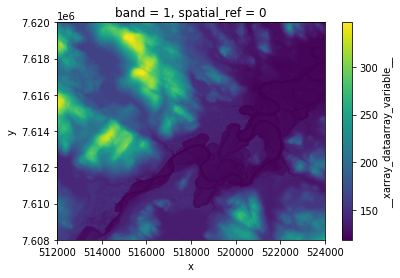

In [36]:
dem.squeeze().plot.imshow()

## Step 2: Fetch coordinates of the river

To get coordinates of the river, we can use freely available [OpenStreetMap](https://www.openstreetmap.org/) data. 

Thanks to [OSMnx](https://github.com/gboeing/osmnx), we can automatically obtain a GeoPandas DataFrame from OSM data.

We thus only need to find out the river's [Way](https://wiki.openstreetmap.org/wiki/Way) ID. Using the [OSM editor](https://www.openstreetmap.org/edit), we find out it's [34406947](https://www.openstreetmap.org/way/34406947).

#### **VIDEO**: How to get OSM ID

**Note**: To get the id when the river is selected in the OSM editor, press `ctrl`+`i`.

In [25]:
Video("data/howto-osm-id.mp4", embed=True)

In [ ]:
osm_id = 'W34406947'

river = ox.geocode_to_gdf(osm_id, by_osmid=True)
river = river.to_crs(dem.rio.crs)

Let's plot the river

<AxesSubplot:>

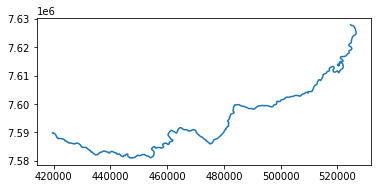

In [10]:
river.plot()

## Step 3: Cut to area of interest

In [11]:
xmin, ymin, xmax, ymax = 5.16e5, 7.6095e6, 5.23e5, 7.6155e6
bounds = box(xmin, ymin, xmax, ymax)

#### River

In [12]:
river = river.clip(bounds)
river_geom = river.geometry.iloc[0]

#### DEM

In [13]:
dem = dem.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

Let's check if everything looks good

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

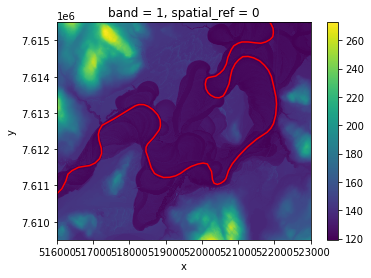

In [14]:
fig, ax = plt.subplots()
dem.squeeze().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

## Step 4: Calculate REM

To calculate the REM, we need to 
1. Sample the elevation along the river
2. Interpolate the sampled elevation values to create a 2D elevation raster
3. Subtract the interpolated elevation raster from the DEM

### 4.1. Sample

Extract coordinates as `DataArray`

In [15]:
xs, ys = river_geom.xy
xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

Use xarray's [`interp`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.interp.html#xarray.DataArray.interp) to extract the river's elevation.

In [16]:
sampled = dem.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

### 4.2. Interpolate

Prepare data for the interpolation

In [17]:
# Sampled river coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# All (x, y) coordinates of the original DEM
c_x, c_y = [dem.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = sampled.values.ravel()

Perform the interpolation. Here we use a simple implementation of [IWD](https://en.wikipedia.org/wiki/Inverse_distance_weighting) which averages the 5 nearest points, weighted by inverse distance.

In [18]:
tree = KDTree(c_sampled)

In [19]:
# IWD interpolation
distances, indices = tree.query(c_interpolate, k=5)

weights = 1 / distances
weights = weights / weights.sum(axis=1).reshape(-1, 1)

interpolated_values = (weights * values[indices]).sum(axis=1)

We create a `DataArray` out of the inerpolated values

In [20]:
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

<AxesSubplot:xlabel='x', ylabel='y'>

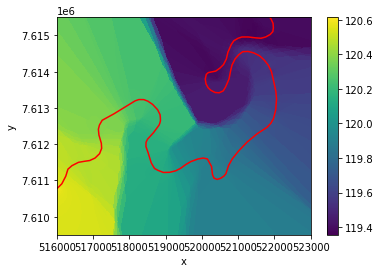

In [21]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

### 4.3. Calculate

In [22]:
rem = dem - elevation_raster

# Step 5: Visualize

Let's make some pretty REM visualizations!

In [23]:
colors = ['#f2f7fb', '#81a8cb', '#37123d']

In [ ]:
shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')

![](https://i.imgur.com/MFagpMt.jpg)

We can also visualize the DEM along with the REM

In [ ]:
a = shade(xrspatial.hillshade(dem.squeeze(), angle_altitude=1, azimuth=310), cmap=['black', 'white'], how='linear')
b = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200)
stack(a, b)

![](https://i.imgur.com/jRXcHVi.jpg)